# 1. Import Dependencies and Data

In [ ]:
!pip install tensorflow-datasets ipywidgets

In [ ]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [ ]:
gpus

In [1]:
import tensorflow_datasets as tfds
from matplotlib import pyplot as plt

In [2]:
ds = tfds.load('fashion_mnist', split='train')

In [3]:
ds.as_numpy_iterator().next().keys()

dict_keys(['image', 'label'])

In [5]:
ds.as_numpy_iterator().next()['label']

2

In [4]:
ds.take(1)

<_TakeDataset element_spec={'image': TensorSpec(shape=(28, 28, 1), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

# 2. Vis Data and Build Dataset

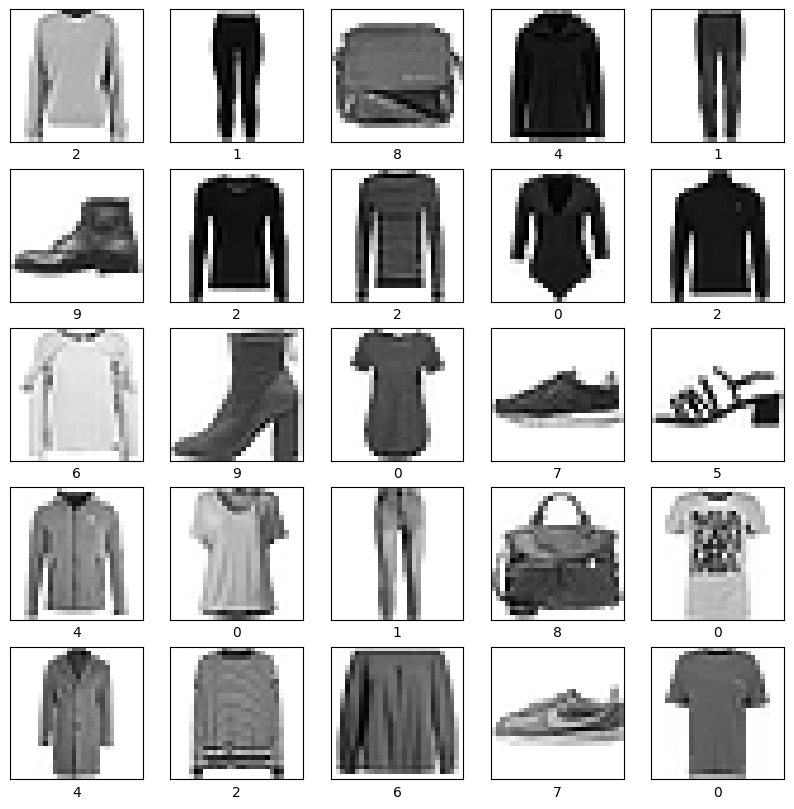

In [9]:
import numpy as np

dataIterator = ds.as_numpy_iterator()
def get_images_and_labels(dataIterator, num_samples=25):
    images = []
    labels = []
    for _ in range(num_samples):
        data = dataIterator.next()
        images.append(data['image'])
        labels.append(data['label'])
    return np.array(images), np.array(labels)
images, labels = get_images_and_labels(dataIterator, 25)
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i].squeeze(), cmap=plt.cm.binary)
    plt.xlabel(labels[i])

In [10]:
def scale_images(data):
    image = data['image']
    return image/ 255

In [15]:
ds = tfds.load('fashion_mnist', split='train')      # Load the Fashion MNIST training dataset (60,000 images)
ds = ds.map(scale_images)                           # Apply image scaling (e.g., normalize pixel values to 0–1)
ds = ds.cache()                                     # Cache data in memory or disk after preprocessing
ds = ds.shuffle(60000)                              # Randomly shuffle the dataset with buffer size = 60,000
ds = ds.batch(128)                                  # Group the dataset into batches of 128 samples
ds = ds.prefetch(64)                                # Prefetch 64 batches asynchronously to improve performance


In [16]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

# 3. Build Neural Network

### 3.1 Import Modeling Component

In [17]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, BatchNormalization, Dropout, UpSampling2D

### 3.2 Build Generator

In [30]:
def build_generator():
    model = Sequential()                          # Initialize a sequential neural network model

    model.add(Dense(7 * 7 * 128, input_dim=128)) # Fully connected layer transforming 128-dim noise to 7*7*128 units
    model.add(LeakyReLU(alpha=0.2))              # Apply Leaky ReLU activation with alpha=0.2 to introduce non-linearity
    model.add(Reshape((7, 7, 128)))               # Reshape the output vector to a 3D tensor with shape 7x7x128

    model.add(UpSampling2D())                     # Upsample the feature map to double its size (14x14)
    model.add(Conv2D(128, 5, padding='same'))  # Convolutional layer with 128 filters, kernel size 5x5, and 'same' padding
    model.add(LeakyReLU(alpha=0.2))              # Apply Leaky

    model.add(UpSampling2D())                     # Upsample the feature map to double its size (28x28)
    model.add(Conv2D(128, 5, padding='same'))  # Convolutional layer with 128 filters, kernel size 5x5, and 'same' padding
    model.add(LeakyReLU(alpha=0.2))              # Apply Leaky

    model.add(Conv2D(128,4, padding='same'))  # Convolutional layer with 128 filters, kernel size 4x4, and 'same' padding
    model.add(LeakyReLU(alpha=0.2))              # Apply Leaky

    model.add(Conv2D(128, 4, padding='same'))  # Convolutional layer with 128 filters, kernel size 4x4, and 'same' padding
    model.add(LeakyReLU(alpha=0.2))              # Apply Leaky

    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))  # Final convolutional layer with 1 filter, kernel size 4x4, 'same' padding, and sigmoid activation
    
    return model                                 # Return the constructed generator model


In [33]:
generator = build_generator()

In [34]:
generator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_5 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_3 (UpSamplin  (None, 14, 14, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

1/1 [==============================] - 0s 102ms/step


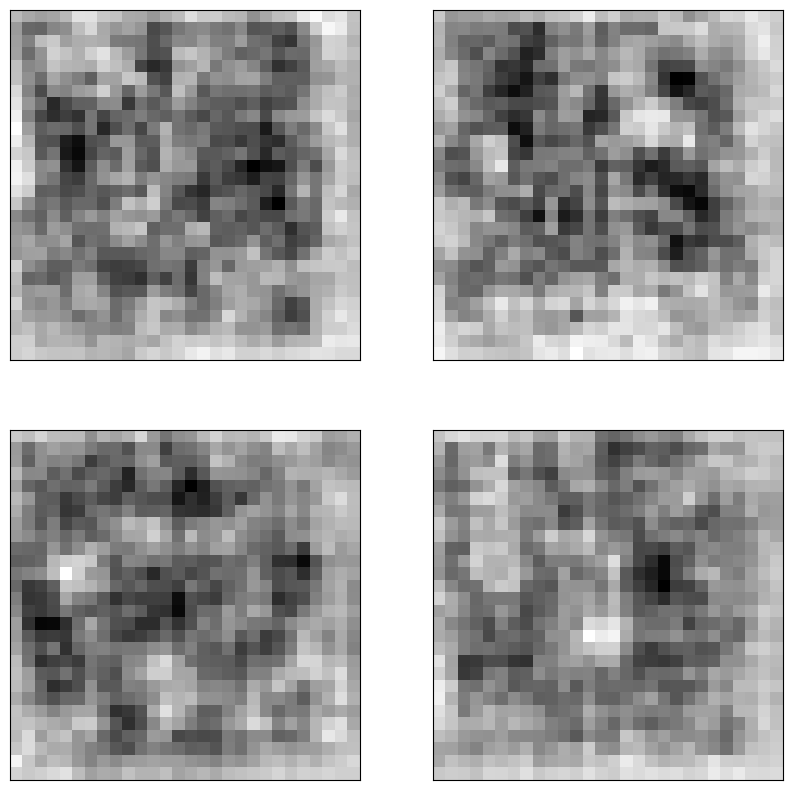

In [39]:
img = generator.predict(np.random.randn(4, 128, 1))  # Generate 4 images from random noise vectors of size 128
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img[i].squeeze(), cmap=plt.cm.binary)  # Display each generated image in grayscale

In [37]:
img.shape

(4, 28, 28, 1)

### 3.3 Build Descriminator

In [49]:
def build_discriminator():
    model = Sequential()                          # Initialize a sequential neural network model

    model.add(Conv2D(32, 5, input_shape=(28, 28, 1)))  # Convolutional layer with 32 filters, kernel size 5x5, input shape 28x28x1
    model.add(LeakyReLU(alpha=0.2))              # Apply Leaky ReLU activation with alpha=0.2 to introduce non-linearity
    model.add(Dropout(0.4))              # Apply dropout with a rate of 0.4 to prevent overfitting

    model.add(Conv2D(64, 5))                            # Convolutional layer with 64 filters, kernel size 5x5
    model.add(LeakyReLU(alpha=0.2))              # Apply Leaky ReLU activation with alpha=0.2 to introduce non-linearity
    model.add(Dropout(0.4))              # Apply dropout with a rate of 0.4 to prevent overfitting

    model.add(Conv2D(128, 5))                           # Convolutional layer with 128 filters, kernel size 5x5
    model.add(LeakyReLU(alpha=0.2))              # Apply Leaky ReLU activation with alpha=0.2 to introduce non-linearity
    model.add(Dropout(0.4))              # Apply dropout with a rate of 0.4 to prevent overfitting

    model.add(Conv2D(256, 5))                           # Convolutional layer with 256 filters, kernel size 5x5
    model.add(LeakyReLU(alpha=0.2))              # Apply Leaky ReLU activation with alpha=0.2 to introduce non-linearity
    model.add(Dropout(0.4))              # Apply dropout with a rate of 0.4 to prevent overfitting

    model.add(Flatten())                                 # Flatten the output tensor to a 1D vector
    model.add(Dropout(0.4))              # Apply dropout with a rate of 0.4 to prevent overfitting
    model.add(Dense(1, activation='sigmoid'))  # Fully connected layer with 1 output unit and sigmoid activation for binary classification

    return model                                 # Return the constructed discriminator model

In [50]:
discriminator = build_discriminator()

In [51]:
discriminator.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_25 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_10 (Dropout)        (None, 24, 24, 32)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_26 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_11 (Dropout)        (None, 20, 20, 64)        0         
                                                                 
 conv2d_23 (Conv2D)          (None, 16, 16, 128)     

In [52]:
discriminator.predict(img)

1/1 [==============================] - 0s 470ms/step


array([[0.5030988 ],
       [0.50308025],
       [0.50313544],
       [0.5032617 ]], dtype=float32)

# 4. Construct Training Loop

### 4.1 Setup Losses and Optimization

### 4.2 Build Subclassed Model

### 4.3 Train

### 4.4 Review Performance

# 5. Test out the Generator

### 5.1 Generate Images

### 5.2 Save the Model